For a while I've been meaning to put together a collection of sets of related compounds for use in teaching and some other experiments. I'll do that by taking compounds from patent data found in ChEMBL. 

> I could also have worked with SureChEMBL for this, but ChEMBL is easier for me to work with (since I always have a copy of ChEMBL arounnd) and contains enough patent data for my purposes. I will probably also take advantage of the fact that there is bioactivity data associated with these compounds in ChEMBL at some point in the future.

In this post I put together the queries, grab the data, and do a bit of initial exploration. I'll do more with these in the futre


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')

%load_ext sql
%matplotlib inline
%config SqlMagic.feedback=0

# Creating the data sets

Look at the number of compounds in the ChEMBL patents:

In [3]:
%sql postgresql://localhost/chembl_36 \
  select patent_id,chembl_id,count(distinct molregno) mrn_count from docs join compound_records using (doc_id) \
   where patent_id is not null \
   group by (patent_id,chembl_id)\
   order by mrn_count desc limit 10; 

patent_id,chembl_id,mrn_count
US-9718790-B2,CHEMBL5725546,2236
US-20130252896-A1,CHEMBL4420062,1901
US-11286268-B1,CHEMBL5729040,1775
US-8466108-B2,CHEMBL4419170,1689
US-11618753-B2,CHEMBL5729657,1530
US-9302989-B2,CHEMBL3886617,1518
US-9796708-B2,CHEMBL5726550,1352
US-11124486-B2,CHEMBL5728711,1227
US-10774051-B2,CHEMBL5727936,1204
US-9303033-B2,CHEMBL3886195,1175


I'm not looking for patents with that many compounds... let's limit it to between 50 and 300:

In [4]:
%sql postgresql://localhost/chembl_36 \
  select count(*) from (select patent_id,chembl_id,count(distinct molregno) mrn_count\
                        from docs join compound_records using (doc_id) \
                        where patent_id is not null \
                        group by (patent_id,chembl_id)\
                        order by mrn_count desc) tmp \
    where mrn_count>50 and mrn_count<300; 

count
2721


That's a lot


Create a temporary table with the count of the number of unique compounds in each of the patents that contains between 50 and 300 compounds.

In [8]:
%sql postgresql://localhost/chembl_36 \
  drop table if exists patents

%sql postgresql://localhost/chembl_36 \
  select * into temporary table patents from \
    (select patent_id,chembl_id,doc_id,count(distinct molregno) mrn_count\
     from docs join compound_records using (doc_id) \
     where patent_id is not null \
     group by (patent_id,chembl_id,doc_id)\
     order by mrn_count desc) tmp \
  where mrn_count>50 and mrn_count<300;

++
||
++
++

In [9]:
%sql postgresql://localhost/chembl_36 \
   select count(*) from patents;

count
2721


In [10]:
%sql postgresql://localhost/chembl_36 \
   select count(*) from (select distinct on (doc_id) doc_id from patents) tmp;

count
2721


For each of those patents, get the counts of the number of activity values for each single-protein assay in the patent. Also pulls info about the assay itself

In [11]:
%sql postgresql://localhost/chembl_36 \
  drop table if exists patent_all_targets

%sql postgresql://localhost/chembl_36 \
   select assays.chembl_id assay_chembl_id,target_dictionary.chembl_id target_chembl_id,\
          pref_name,target_type,count(distinct molregno) act_count, tid, assay_id,assays.doc_id\
   into temporary table patent_all_targets \
   from patents join assays using (doc_id) join activities using (assay_id) \
       join target_dictionary using (tid) \
   where pchembl_value is not null and target_type='SINGLE PROTEIN'\
   group by (assays.chembl_id,target_dictionary.chembl_id,pref_name,target_type,tid, assay_id,assays.doc_id) \
   order by act_count desc;

++
||
++
++

In [12]:
%sql postgresql://localhost/chembl_36 \
   select count(*) from (select distinct on (doc_id) doc_id from patent_all_targets) tmp;

count
2334


Get the most populated target for each patent. We will call this the target for the patent (though this is clearly a crude assumption).

The `distinct on (doc_id)` thing combined with the `order by doc_id, act_count desc` is the way to get the row for each `doc_id` that has the highest `act_count` in postgresql.

In [13]:
%sql postgresql://localhost/chembl_36 \
  drop table if exists patent_targets

%sql postgresql://localhost/chembl_36 \
   select distinct on (doc_id) \
      assay_chembl_id,target_chembl_id,pref_name,act_count,tid,assay_id,doc_id \
    into temporary table patent_targets \
    from patent_all_targets order by doc_id, act_count desc;

++
||
++
++

In [14]:
%sql select count(distinct target_chembl_id) from patent_targets;

count
641


Find the most popular targets and the number of patents assigned to each:

In [15]:
%sql postgresql://localhost/chembl_36 \
 select target_chembl_id,pref_name,count(distinct doc_id) num_patents,tid \
  from patent_targets \
  group by (target_chembl_id,pref_name,tid) \
  order by num_patents desc limit 10;

target_chembl_id,pref_name,num_patents,tid
CHEMBL5251,Tyrosine-protein kinase BTK,61,100097
CHEMBL6136,Lysine-specific histone demethylase 1A,56,102439
CHEMBL1741186,Nuclear receptor ROR-gamma,40,103982
CHEMBL2000,Plasma kallikrein,32,23
CHEMBL1163125,Bromodomain-containing protein 4,30,103454
CHEMBL4409,"cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A",29,100010
CHEMBL2815,High affinity nerve growth factor receptor,28,11902
CHEMBL3130,"Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit delta isoform",26,11177
CHEMBL6175,Lysine-specific demethylase 4C,25,102452
CHEMBL2973,Rho-associated protein kinase 2,24,11149


In [17]:
d = %sql postgresql://localhost/chembl_36 \
 select target_chembl_id,num_patents from \
    (select target_chembl_id,pref_name,count(distinct doc_id) num_patents,tid \
     from patent_targets \
     group by (target_chembl_id,pref_name,tid) ) tmp\
  where num_patents >20 \
  order by num_patents desc;
d

target_chembl_id,num_patents
CHEMBL5251,61
CHEMBL6136,56
CHEMBL1741186,40
CHEMBL2000,32
CHEMBL1163125,30
CHEMBL4409,29
CHEMBL2815,28
CHEMBL3130,26
CHEMBL6175,25
CHEMBL2973,24


In [18]:
len(d)

13

Write out the compounds for those 13 targets:

In [19]:
%config SqlMagic.named_parameters="enabled" 
for cid,_ in d:
    targetd = %sql postgresql://localhost/chembl_36 \
      select patent_id, patents.chembl_id patent_chembl_id, chembl_id_lookup.chembl_id compound_chembl_id,\
           canonical_smiles \
        from patents join patent_targets using (doc_id) \
         join compound_records using (doc_id) join molecule_hierarchy using (molregno) \
         join compound_structures cs on (cs.molregno=parent_molregno) \
         join chembl_id_lookup on (parent_molregno=entity_id and entity_type='COMPOUND')\
        where target_chembl_id=:cid
    
    targetd = targetd.DataFrame()
    targetd.to_csv(f'../data/patent_datasets/target_{cid}.csv',index=False)

In [20]:
!head ../data/patent_datasets/target_CHEMBL1163125.csv

patent_id,patent_chembl_id,compound_chembl_id,canonical_smiles
US-8975417-B2,CHEMBL3638496,CHEMBL3650854,COc1ccc(Cn2nc3c(c2C)C(c2ccc(Cl)cc2)N(c2ccc(=O)n(C)c2)C3=O)cc1
US-8975417-B2,CHEMBL3638496,CHEMBL3650855,Cc1[nH]nc2c1C(c1ccc(Cl)cc1)N(c1ccc(=O)n(C)c1)C2=O
US-8975417-B2,CHEMBL3638496,CHEMBL3650856,Cc1c2c(nn1C)C(=O)N(c1ccc(=O)n(C)c1)C2c1ccc(Cl)cc1
US-8975417-B2,CHEMBL3638496,CHEMBL3650857,CC1=NN(C)C2C(=O)N(c3ccc(=O)n(C)c3)C(c3ccc(Cl)cc3)C12
US-8975417-B2,CHEMBL3638496,CHEMBL3650858,Cc1[nH]nc2c1C(c1ccc(Cl)cc1)N(c1cc(Cl)c(=O)n(C)c1)C2=O
US-8975417-B2,CHEMBL3638496,CHEMBL3650859,Cc1c2c(nn1C)C(=O)N(c1cc(Cl)c(=O)n(C)c1)C2c1ccc(Cl)cc1
US-8975417-B2,CHEMBL3638496,CHEMBL3650860,Cc1c2c(nn1C)C(=O)N(c1cc(Cl)c(=O)n(C)c1)[C@@H]2c1ccc(Cl)cc1
US-8975417-B2,CHEMBL3638496,CHEMBL3650861,Cc1c2c(nn1C)C(=O)N(c1cc(Cl)c(=O)n(C)c1)[C@H]2c1ccc(Cl)cc1
US-8975417-B2,CHEMBL3638496,CHEMBL3650862,Cn1cc(N2C(=O)c3n[nH]cc3C2c2ccc(Cl)cc2)cc(Cl)c1=O


# Looking at the some results with UMAP

Let's do a bit of visualization workn by grabbing the data for a single target:

In [21]:
target_id = 'CHEMBL5251'
%sql postgresql://localhost/chembl_36 \
  drop table if exists patent_compounds

%sql postgresql://localhost/chembl_36 \
  select patent_id,patents.chembl_id patent_chembl_id,chembl_id_lookup.chembl_id compound_chembl_id,canonical_smiles \
    into temporary table patent_compounds \
    from patents join patent_targets using (doc_id) \
     join compound_records using (doc_id) join molecule_hierarchy using (molregno) join compound_structures cs on (cs.molregno=parent_molregno) \
     join chembl_id_lookup on (parent_molregno=entity_id and entity_type='COMPOUND')\
    where target_chembl_id=:target_id;

++
||
++
++

In [22]:
%sql select count(*) from patent_compounds

count
8450


In [23]:
%sql select * from patent_compounds limit 10;

patent_id,patent_chembl_id,compound_chembl_id,canonical_smiles
US-8618107-B2,CHEMBL3639120,CHEMBL3670078,Cc1c(-c2cc(Nc3cc4n(n3)CCN(C)C4)c(=O)[nH]n2)cccc1N1CCn2c(cc3c2CCCC3)C1=O
US-8618107-B2,CHEMBL3639120,CHEMBL3670079,Cc1c(-c2cc(Nc3cc4n(n3)CCN(C)C4)c(=O)[nH]n2)cccc1N1CCn2c(cc3ccccc32)C1=O
US-8618107-B2,CHEMBL3639120,CHEMBL3670080,Cc1c(-c2cc(Nc3cc4n(n3)CCN(C)C4)c(=O)n(C)n2)cccc1N1Cc2c(sc3ccccc23)C1=O
US-8618107-B2,CHEMBL3639120,CHEMBL3670081,Cn1cc(-c2cccc(N3CCc4c(sc5c4CCCC5)C3=O)c2CO)cc(Nc2ccncn2)c1=O
US-8618107-B2,CHEMBL3639120,CHEMBL3670082,Cn1cc(-c2cccc(N3CCc4c(sc5c4CC(C)(C)C5)C3=O)c2CO)cc(Nc2ccncn2)c1=O
US-8618107-B2,CHEMBL3639120,CHEMBL3670083,Cn1cc(-c2cccc(N3CCn4c(cc5c4CCCC5)C3=O)c2CO)cc(Nc2cc(C3CC3)n[nH]2)c1=O
US-8618107-B2,CHEMBL3639120,CHEMBL3670084,Cn1cc(-c2cccc(N3CCn4c(cc5c4CCCC5)C3=O)c2CO)cc(Nc2ccc(N3CCOCC3)cn2)c1=O
US-8618107-B2,CHEMBL3639120,CHEMBL3670085,CC(=O)N1CCn2nc(Nc3cc(-c4cccc(N5CCn6c(cc7c6CCCC7)C5=O)c4CO)cn(C)c3=O)cc2C1
US-8618107-B2,CHEMBL3639120,CHEMBL3670086,Cn1cc(-c2cccc(N3CCn4c(cc5c4CCCC5)C3=O)c2CO)cc(Nc2ccncn2)c1=O
US-8618107-B2,CHEMBL3639120,CHEMBL3670087,Cn1cc(-c2cccc(N3CCn4c(cc5c4CCCC5)C3=O)c2CO)cc(Nc2cc3n(n2)CCOC3)c1=O


Start with a subset of 12 patents, sorted by number of compounds they contain.

We will have a bunch of duplicate compounds. For this exercise, pick each compound only once:

In [24]:
d = %sql \
  select distinct on (compound_chembl_id) * from patent_compounds \
   join (select patent_id from patent_compounds group by patent_id \
         order by count(distinct compound_chembl_id) desc \
         limit 12) tmp \
   using (patent_id)\
   order by compound_chembl_id, patent_id;

In [25]:
df = d.DataFrame()
df.head()

,patent_id,patent_chembl_id,compound_chembl_id,canonical_smiles
0,US-10828300-B2,CHEMBL5728085,CHEMBL2216827,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(Oc4ccnc(C(=O)NC)c...
1,US-10828300-B2,CHEMBL5728085,CHEMBL3301625,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(OCCOC)cc3)ncc2F)c1
2,US-9447106-B2,CHEMBL3886959,CHEMBL3889791,C=CC(=O)Nc1cc(C2CCNc3c(C(N)=O)c(-c4ccc(Oc5cccc...
3,US-9447106-B2,CHEMBL3886959,CHEMBL3890068,C=CC(=O)Nc1ccccc1C1CCNc2c(C(N)=O)c(-c3ccc(OCCO...
4,US-9447106-B2,CHEMBL3886959,CHEMBL3890197,NC(=O)c1c(-c2ccc(Oc3ccccc3)cc2)nn2c1NC(=O)C21C...


In [26]:
df.shape,len(set(df['canonical_smiles']))

((1656, 4), 1656)

Add fingerprints:

In [27]:
df['Mol'] = df['canonical_smiles'].apply(Chem.MolFromSmiles)

In [28]:
from rdkit.Chem import rdFingerprintGenerator
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
df['cmfp3'] = df['Mol'].apply(fpg.GetCountFingerprintAsNumPy)

Now do UMAP using the Dice similarity metric. I did a bit of exploration to come up with the values of `n_neighbors` and `min_dist` used here.

In [29]:
import umap
fitter = umap.UMAP(n_neighbors=8,min_dist=0.4,metric='dice',n_jobs=4)
pts = fitter.fit_transform(df['cmfp3'].tolist())
df['X'] = pts[:,0]
df['Y'] = pts[:,1]


/home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


And do a scatter plot of the results:

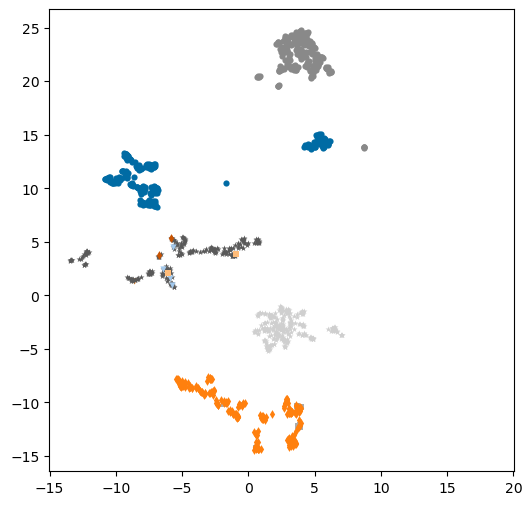

In [30]:
plt.figure(figsize=(6,6))
markers = 'ovs*+d'
for i,pid in enumerate(set(df['patent_chembl_id'])):
    tdf = df[df['patent_chembl_id']==pid]
    plt.scatter(tdf['X'],tdf['Y'],label=pid,marker=markers[i%len(markers)],s=20,linewidth=0);

Look at a couple of different targets together

In [31]:
dfs = []
for target_id in ('CHEMBL3864','CHEMBL3130','CHEMBL4409'):
    %sql postgresql://localhost/chembl_36 \
      drop table if exists patent_compounds

    %sql postgresql://localhost/chembl_36 \
      select patent_id,patents.chembl_id patent_chembl_id,chembl_id_lookup.chembl_id compound_chembl_id,canonical_smiles \
        into temporary table patent_compounds \
        from patents join patent_targets using (doc_id) \
         join compound_records using (doc_id) join molecule_hierarchy using (molregno) join compound_structures cs on (cs.molregno=parent_molregno) \
         join chembl_id_lookup on (parent_molregno=entity_id and entity_type='COMPOUND')\
        where target_chembl_id=:target_id;
    d = %sql \
  select distinct on (compound_chembl_id) * from patent_compounds \
   join (select patent_id from patent_compounds group by patent_id \
         order by count(distinct compound_chembl_id) desc \
         limit 12) tmp \
   using (patent_id)\
   order by compound_chembl_id, patent_id;
    df = d.DataFrame()
    df['target_chembl_id'] = target_id
    dfs.append(df)
hybrid = pd.concat(dfs)

In [32]:
hybrid.shape

(4642, 5)

In [33]:
hybrid['Mol'] = hybrid['canonical_smiles'].apply(Chem.MolFromSmiles)
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
hybrid['cmfp3'] = hybrid['Mol'].apply(fpg.GetCountFingerprintAsNumPy)

fitter = umap.UMAP(n_neighbors=8,min_dist=0.4,metric='dice',n_jobs=4)
pts = fitter.fit_transform(hybrid['cmfp3'].tolist())
hybrid['X'] = pts[:,0]
hybrid['Y'] = pts[:,1]

/home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
/home/glandrum/mambaforge/envs/rdkit_blog/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


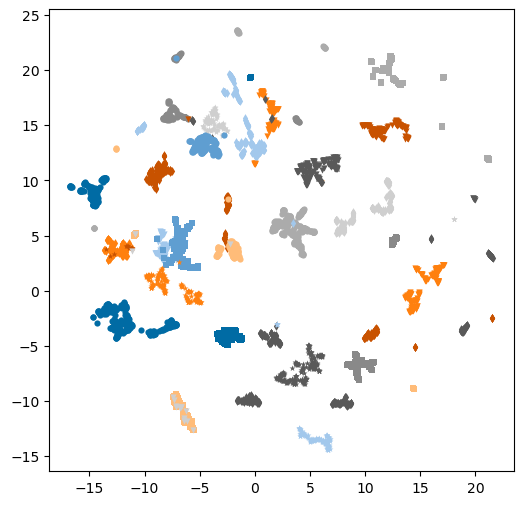

In [34]:
plt.figure(figsize=(6,6))
markers = 'ovs*+d'
for i,pid in enumerate(set(hybrid['patent_chembl_id'])):
    tdf = hybrid[hybrid['patent_chembl_id']==pid]
    plt.scatter(tdf['X'],tdf['Y'],label=pid,marker=markers[i%len(markers)],s=20,linewidth=0);

Color by target id instead of patent:

CHEMBL4409: cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A
CHEMBL3130: Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit delta isoform
CHEMBL3864: Tyrosine-protein phosphatase non-receptor type 11


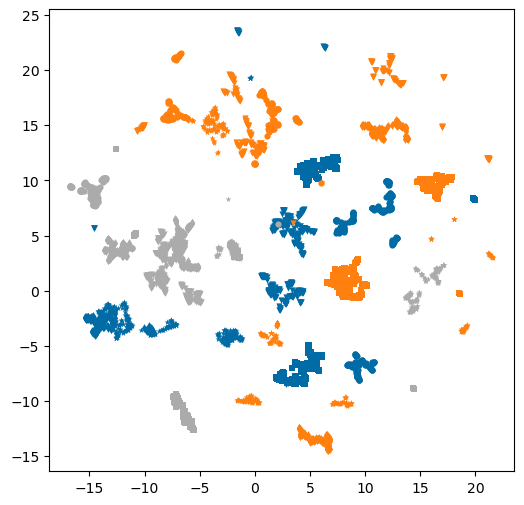

In [40]:
plt.figure(figsize=(6,6))
markers = 'ovs*+d'
for i,tid in enumerate(set(hybrid['target_chembl_id'])):
    d = %sql postgresql://localhost/chembl_36 \
      select pref_name from target_dictionary where chembl_id=:tid
    print(f'{tid}: {d[0][0]}')
    tdf = hybrid[hybrid['target_chembl_id']==tid]
    for j,pid in enumerate(set(tdf['patent_chembl_id'])):
        pdf = tdf[tdf['patent_chembl_id']==pid]
        plt.scatter(pdf['X'],pdf['Y'],label=pid,marker=markers[j%len(markers)],s=20,linewidth=0,c=f'C{i}');

That's enough for now... these compound sets are sure to show up in future blog posts. 